In [2]:
from keras.layers import Input, Dense, Lambda, Flatten, Activation, Merge, Concatenate, Add
from keras import layers
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import numpy as np
from scipy.stats import sem
from scipy.spatial.distance import squareform, pdist
from keras import backend as K
from keras.models import load_model
import tensorflow as tf


from models import vgg
from models.cvae import CVAE
from models.cvae_mod import CVAE as CVAE_mod
from utils.losses import von_mises_log_likelihood_np
from utils.angles import deg2bit, bit2deg
from utils.losses import mad_loss_tf, cosine_loss_tf, von_mises_loss_tf, maad_from_deg
from utils.losses import gaussian_kl_divergence_tf, gaussian_kl_divergence_np
from utils.losses  import von_mises_log_likelihood_tf, von_mises_log_likelihood_np
from utils.towncentre import load_towncentre
from utils.experiements import get_experiment_id

Using TensorFlow backend.


In [3]:
xtr, ytr_deg, xval, yval_deg, xte, yte_deg = load_towncentre('data/TownCentre.pkl.gz', canonical_split=True, verbose=1)

image_height, image_width = xtr.shape[1], xtr.shape[2]
ytr_bit = deg2bit(ytr_deg)
yval_bit = deg2bit(yval_deg)
yte_bit = deg2bit(yte_deg)
yte_rad = np.deg2rad(yte_deg)

image_height, image_width, n_channels = xtr.shape[1:]
flatten_x_shape = xtr[0].flatten().shape[0]
phi_shape = yte_bit.shape[1]

Number of train samples: 6916
Number of validation samples: 874
Number of test samples: 904


#### Loading pre-trained models

#### Biternion-VGG (Log-likelihood, fixed $\kappa=3$)

In [4]:
vgg_fixed_kappa = vgg.BiternionVGG(image_height=image_height,
                                   image_width=image_width,
                                   n_channels=3,
                                   predict_kappa=False,
                                   fixed_kappa_value=3.0)

vgg_fixed_kappa.model.load_weights('logs/best_models/fixed_kappa/vgg_bit_vm_likelihood_town.best.weights.h5')

In [5]:
results_fixed = dict()
#results_fixed['train'] = vgg_fixed_kappa.evaluate(xtr, ytr_deg, 'train')
results_fixed['validation'] = vgg_fixed_kappa.evaluate(xval, yval_deg, 'validation')
results_fixed['test'] = vgg_fixed_kappa.evaluate(xte, yte_deg, 'test')

MAAD error (validation) : 22.728342 ± 0.990586SEM
log-likelihood (validation) : -0.870462 ± 0.035802SEM
MAAD error (test) : 24.155143 ± 1.088582SEM
log-likelihood (test) : -0.929270 ± 0.039672SEM


#### Biternion-VGG (Log-likelihood, learned $\kappa$)

In [6]:
vgg_learned_kappa = vgg.BiternionVGG(image_height=image_height,
                                     image_width=image_width,
                                     n_channels=3,
                                     predict_kappa=True)

vgg_learned_kappa.model.load_weights('logs/best_models/learned_kappa/vgg_bit_vm_likelihood_town.best.weights.h5')

In [7]:
results_learned = dict()
#results_learned['train'] = vgg_learned_kappa.evaluate(xtr, ytr_deg, 'train')
results_learned['validation'] = vgg_learned_kappa.evaluate(xval, yval_deg, 'validation')
results_learned['test'] = vgg_learned_kappa.evaluate(xte, yte_deg, 'test')

MAAD error (validation) : 24.398405 ± 1.090128SEM
log-likelihood (validation) : -0.802889 ± 0.078568SEM
MAAD error (test) : 24.327137 ± 1.095842SEM
log-likelihood (test) : -0.764323 ± 0.066594SEM


#### Biternion-VGG (cosine-loss)

In [8]:
vgg_cosine = vgg.BiternionVGG(image_height=image_height,
                              image_width=image_width,
                              n_channels=3,
                              predict_kappa=False,
                              fixed_kappa_value=3.0)

vgg_cosine.model.load_weights('logs/best_models/cosine/vgg_bit_cosine_town.best.weights.h5')

In [9]:
results_cosine = dict()
#results_cosine['train'] = vgg_cosine.evaluate(xtr, ytr_deg, 'train')
results_cosine['validation'] = vgg_cosine.evaluate(xval, yval_deg, 'validation')
results_cosine['test'] = vgg_cosine.evaluate(xte, yte_deg, 'test')

MAAD error (validation) : 21.833931 ± 0.966800SEM
log-likelihood (validation) : -0.843196 ± 0.034713SEM
MAAD error (test) : 24.108348 ± 1.069605SEM
log-likelihood (test) : -0.926001 ± 0.038936SEM


#### Biternion-VGG (Von-Mises loss)

In [10]:
vgg_vm = vgg.BiternionVGG(image_height=image_height,
                          image_width=image_width,
                          n_channels=3,
                          predict_kappa=False,
                          fixed_kappa_value=3.0)

vgg_vm.model.load_weights('logs/best_models/von_mises/vgg_bit_von_mises_town.best.weights.h5')

In [11]:
results_vm = dict()
#results_vm['train'] = vgg_vm.evaluate(xtr, ytr_deg, 'train')
results_vm['validation'] = vgg_vm.evaluate(xval, yval_deg, 'validation')
results_vm['test'] = vgg_vm.evaluate(xte, yte_deg, 'test')

MAAD error (validation) : 22.974047 ± 0.999363SEM
log-likelihood (validation) : -0.883493 ± 0.036697SEM
MAAD error (test) : 24.156092 ± 1.083819SEM
log-likelihood (test) : -0.925846 ± 0.039583SEM


In [12]:
def maximum_expected_utility(ypreds):
    ix = np.argmin(np.sum(squareform(pdist(ypreds, 'euclidean')), axis=1))
    return float(ypreds[ix])

#### CVAE model - regular training

In [13]:
n_u = 8
cvae = CVAE(n_hidden_units=n_u)
cvae_ckpt_path = 'logs/best_models/cvae/cvae.full_model.overall_best.weights.hdf5'
cvae.full_model.load_weights(cvae_ckpt_path)

In [14]:
results_cvae = dict()
# results_cvae['train'] = cvae_best.evaluate(xtr, ytr_deg, 'train')
results_cvae['validation'] = cvae.evaluate(xval, yval_deg, 'validation')
results_cvae['test'] = cvae.evaluate(xte, yte_deg, 'test')

MAAD error (validation) : 23.796661 ± 1.075040SEM
ELBO (validation) : -0.595410 ± 0.039326SEM
KL-div (validation) : 0.000102 ± 0.000043SEM
MAAD error (test) : 23.377776 ± 1.064720SEM
ELBO (test) : -0.665743 ± 0.062994SEM
KL-div (test) : 0.000109 ± 0.000045SEM


In [15]:
y_pred = cvae.full_model.predict([xte, yte_bit])

In [16]:
mu_prior = y_pred[:, 0:n_u]
log_sigma_prior = y_pred[:, n_u:n_u*2]
mu_encoder = y_pred[:, n_u*2:n_u*3]
log_sigma_encoder = y_pred[:, n_u*3:n_u*4]
mu_pred = y_pred[:, n_u*4:n_u*4+2]
kappa_pred = y_pred[:, n_u*4+2:]

In [17]:
y_pred_decoder = cvae.decoder_model.predict(xte)

In [18]:
n_samples = 50

cvae_mu_rad_preds  = np.zeros([n_samples, xte.shape[0], 1])
cvae_kappa_preds  = np.zeros([n_samples, xte.shape[0], 1])
cvae_mu_bit_preds = np.zeros([n_samples, xte.shape[0], 2])

for i in range(0, n_samples):
    cvae_preds = cvae.decoder_model.predict(xte)
    cvae_mu_bit_preds[i,:,:] = cvae_preds[:,0:2]
    cvae_mu_rad_preds[i,:,:] = np.deg2rad(bit2deg(cvae_preds[:,0:2])).reshape(-1,1)
    cvae_kappa_preds[i,:,:] = cvae_preds[:,2].reshape(-1,1)

In [19]:
mc_log_like = [np.mean(von_mises_log_likelihood_np(np.tile(yte_bit[i], [n_samples, 1]), cvae_mu_bit_preds[:,i,0:2], cvae_kappa_preds[:,i,0].reshape(-1,1))) for i in range(0, cvae_preds.shape[0])]
cvae_mu_rad_preds_mae = [maximum_expected_utility(cvae_mu_rad_preds[:,i,:]) for i in range(0, cvae_mu_rad_preds.shape[1])]
maad_errors = maad_from_deg(np.rad2deg(cvae_mu_rad_preds_mae), yte_deg)
print("MAAD error (test, cvae-MAE) : %f ± %fSEM" % (np.mean(maad_errors), sem(maad_errors)))
print("Monte-Carlo log-likelihood (test, cvae) : %f ± %fSEM" % (np.mean(mc_log_like), sem(mc_log_like)))

MAAD error (test, cvae-MAE) : 23.441104 ± 1.065601SEM
Monte-Carlo log-likelihood (test, cvae) : -0.668419 ± 0.063449SEM


#### CVAE model - trained with KL annelaing (0.5->0.75->1.0) 

In [20]:
n_u = 8
cvaekl = CVAE(n_hidden_units=n_u)
cvaekl_ckpt_path = 'logs/best_models/cvae/kl_reduction_exepriments/1/cvae.full_model.overall_best.weights.hdf5'
cvaekl.full_model.load_weights(cvaekl_ckpt_path)

In [35]:
results_cvaekl = dict()
# results_cvae['train'] = cvae_best.evaluate(xtr, ytr_deg, 'train')
results_cvaekl['validation'] = cvaekl.evaluate(xval, yval_deg, 'validation')
results_cvaekl['test'] = cvaekl.evaluate(xte, yte_deg, 'test')

MAAD error (validation) : 26.303375 ± 1.138009SEM
ELBO (validation) : -0.739446 ± 0.054143SEM
KL-div (validation) : 0.152628 ± 0.012068SEM
MAAD error (test) : 28.146599 ± 1.260927SEM
ELBO (test) : -0.708444 ± 0.054591SEM
KL-div (test) : 0.161246 ± 0.013767SEM


#### Using Maximum Expected Utility for MAAD calculation and Monte-Carlo estimation of log-likelihood

In [22]:
def get_estimates(cvae_model, x, y_bit,  n_samples=1):
    mu_rad_preds  = np.zeros([n_samples, x.shape[0], 1])
    mu_bit_preds = np.zeros([n_samples, x.shape[0], 2])
    kappa_preds  = np.zeros([n_samples, x.shape[0], 1])
    marg_loglike_preds = np.zeros([n_samples, x.shape[0], 1])
    kl_preds = np.zeros([n_samples, x.shape[0], 1])
    elbo_preds = np.zeros([n_samples, x.shape[0], 1])

    mu_rad_preds_dec  = np.zeros([n_samples, x.shape[0], 1])
    mu_bit_preds_dec = np.zeros([n_samples, x.shape[0], 2])
    kappa_preds_dec  = np.zeros([n_samples, x.shape[0], 1])

    for i in range(0, n_samples):
        preds = cvae_model.full_model.predict([x, y_bit])
        mu_bit_preds[i,:,:] =  preds[:, n_u*4:n_u*4+2]
        mu_rad_preds[i,:,:] = np.deg2rad(bit2deg(preds[:, n_u*4:n_u*4+2])).reshape(-1,1)
        kappa_preds[i,:,:] = preds[:, n_u*4+2:].reshape(-1,1)
        elbo, marg_log_likelihood, kl = cvaekl._cvae_elbo_loss_np(y_bit, preds)
        marg_loglike_preds[i,:,:] = marg_log_likelihood
        kl_preds[i,:,:] = kl
        elbo_preds[i,:,:] = elbo 
        preds_dec = cvae_model.decoder_model.predict(x)
        mu_bit_preds_dec[i,:,:] =  preds_dec[:, 0:2]
        mu_rad_preds_dec[i,:,:] = np.deg2rad(bit2deg(preds_dec[:, 0:2])).reshape(-1,1)
        kappa_preds_dec[i,:,:] = preds_dec[:, 2:].reshape(-1,1)

    res = dict()
    
    res['mu_rad_preds'] = mu_rad_preds
    res['mu_bit_preds'] = mu_bit_preds
    res['kappa_preds'] = kappa_preds
    res['marg_loglike_preds'] = marg_loglike_preds
    res['kl_preds'] = kl_preds
    res['elbo_preds'] = elbo_preds
    res['mu_rad_preds_dec'] = mu_rad_preds_dec
    res['mu_bit_preds_dec'] = mu_bit_preds_dec
    res['kappa_preds_dec'] = kappa_preds_dec    
    res['mu_rad_preds_dec_mae'] = [maximum_expected_utility(mu_rad_preds_dec[:,i,:]) for i in range(0, mu_rad_preds_dec.shape[1])]
    
    return res

In [36]:
res_val = get_estimates(cvaekl, xval, yval_bit, n_samples=5)
res_test = get_estimates(cvaekl, xte, yte_bit, n_samples=5)

In [37]:
print("ELBO (validation, cvaekl) : %f ± %fSEM" % (np.mean(res_val['elbo_preds']), sem(res_val['elbo_preds'],axis=None)))
print("ELBO (test, cvaekl) : %f ± %fSEM" % (np.mean(res_test['elbo_preds']), sem(res_test['elbo_preds'],axis=None)))
maad_errors_val = maad_from_deg(np.rad2deg(res_val['mu_rad_preds_dec_mae']), yval_deg)
print("MAAD error (validation, cvaekl-MAE) : %f ± %fSEM" % (np.mean(maad_errors_val), sem(maad_errors_val)))
maad_errors_test = maad_from_deg(np.rad2deg(res_test['mu_rad_preds_dec_mae']), yte_deg)
print("MAAD error (test, cvaekl-MAE) : %f ± %fSEM" % (np.mean(maad_errors_test), sem(maad_errors_test)))

ELBO (validation, cvaekl) : -0.714463 ± 0.022948SEM
ELBO (test, cvaekl) : -0.725018 ± 0.026647SEM
MAAD error (validation, cvaekl-MAE) : 27.417385 ± 1.227814SEM
MAAD error (test, cvaekl-MAE) : 26.364834 ± 1.197873SEM


#### Saving predictions from different model

In [25]:
vm_preds = vgg_vm.model.predict(xte)
vm_preds_mu_rad = np.deg2rad(bit2deg(vm_preds))
vm_preds_kappa = np.ones([xte.shape[0],1])*3
vm_preds_likelihoods = von_mises_log_likelihood_np(yte_bit, vm_preds[:,0:2], vm_preds_kappa)

fixed_preds = vgg_fixed_kappa.model.predict(xte)
fixed_preds_mu_rad = np.deg2rad(bit2deg(fixed_preds))
fixed_preds_kappa = np.ones([xte.shape[0],1])*3
fixed_preds_likelihoods = von_mises_log_likelihood_np(yte_bit, fixed_preds[:,0:2], fixed_preds_kappa)

learned_preds = vgg_learned_kappa.model.predict(xte)
learned_preds_mu_rad = np.deg2rad(bit2deg(learned_preds[:,0:2]))
learned_preds_kappa = learned_preds[:,2:]
learned_preds_likelihoods = von_mises_log_likelihood_np(yte_bit, learned_preds[:,0:2], learned_preds_kappa)

In [26]:
from utils.losses import log_bessel_approx_np

def vm_pdf(vals, mu_rad, kappa):
    return np.exp(kappa * np.cos(vals-mu_rad)) / (2* np.pi * np.exp(log_bessel_approx_np(kappa)))

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_vm_dists(fid):
    x_vals = np.arange(0, 2*np.pi, 0.01)
    
    fig, axs = plt.subplots(1, 7, figsize=(25, 5))
    
    axs[0].imshow(xte[fid])
    
    def _plt_vgg(axis, mu_rad_preds, kappa_preds, method_name):
        axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
        axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]) 
        axis.set_xlim([-0.001, 2*np.pi+0.001])
        axis.plot(x_vals, np.squeeze(vm_pdf(x_vals, mu_rad_preds[fid], kappa_preds[fid])))
        axis.axvline(yte_rad[fid], color='red')
        axis.set_title("%s " % method_name)
        axis.set_ylim([0, 2.0])
        
    def _plt_cvae(axis, cvae_mu_rad_preds, cvae_kappa_preds, method_name, plot_mixture=False):
        axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
        axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]) 
        axis.set_xlim([-0.001, 2*np.pi+0.001])
        vm_vals = np.zeros([n_samples, x_vals.shape[0]])
        if plot_mixture:
            for sid in range(0, n_samples):
                vm_vals[sid, :] = vm_pdf(x_vals, cvae_mu_rad_preds[sid, fid], cvae_kappa_preds[sid, fid])
            axis.plot(x_vals, np.mean(vm_vals, axis=0))
        else:
            for sid in range(0, n_samples):
                axis.plot(x_vals, np.squeeze(vm_pdf(x_vals, cvae_mu_rad_preds[sid, fid], cvae_kappa_preds[sid, fid])))  
        axis.axvline(yte_rad[fid], color='red')
        axis.set_title("%s " % method_name)
        axis.set_ylim([0, 2.0])
        
    _plt_vgg(axs[1], fixed_preds_mu_rad, fixed_preds_kappa, 'original (Von-Mises loss)')
    _plt_vgg(axs[2], fixed_preds_mu_rad, fixed_preds_kappa, 'fixed kappa')
    _plt_vgg(axs[3], learned_preds_mu_rad, learned_preds_kappa, 'learned kappa')
    _plt_cvae(axs[4], cvae_mu_rad_preds, cvae_kappa_preds, "CVAE (normal)")
    _plt_cvae(axs[5], res_test['mu_rad_preds_dec'],  res_test['kappa_preds_dec'], "CVAE (KL annealing)")
    _plt_cvae(axs[6], res_test['mu_rad_preds_dec'], res_test['kappa_preds_dec'], "CVAE (KL annealing, mixture density)", plot_mixture=True)
    fig.suptitle("frame id =%d" %fid)
    #plt.plot((ytr_deg, x2), (y1, y2), 'k-')
    plt.show()

#####  dataset desc http://www.robots.ox.ac.uk/~lav/Papers/benfold_reid_iccv2011/benfold_reid_iccv2011.pdf
#####  https://www.youtube.com/watch?v=eupXTJM_TAw (Demo)

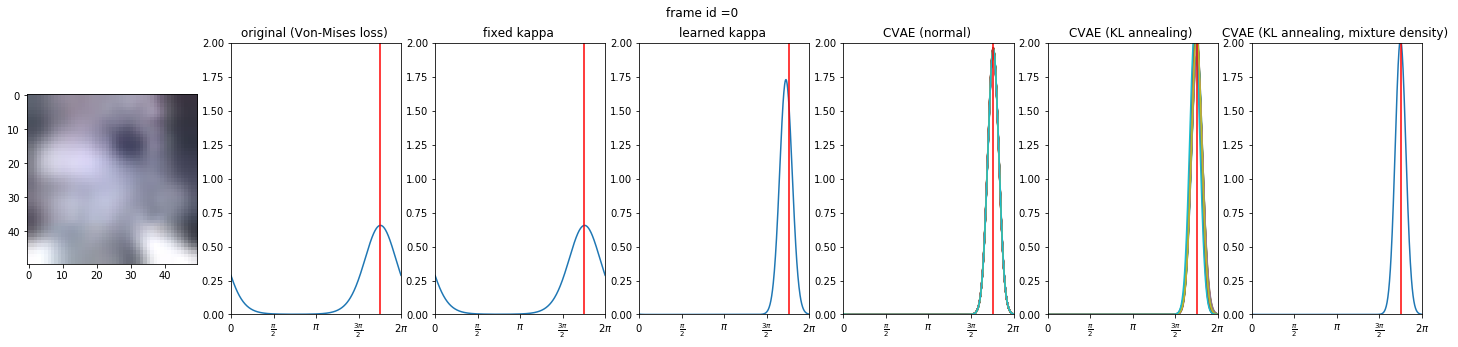

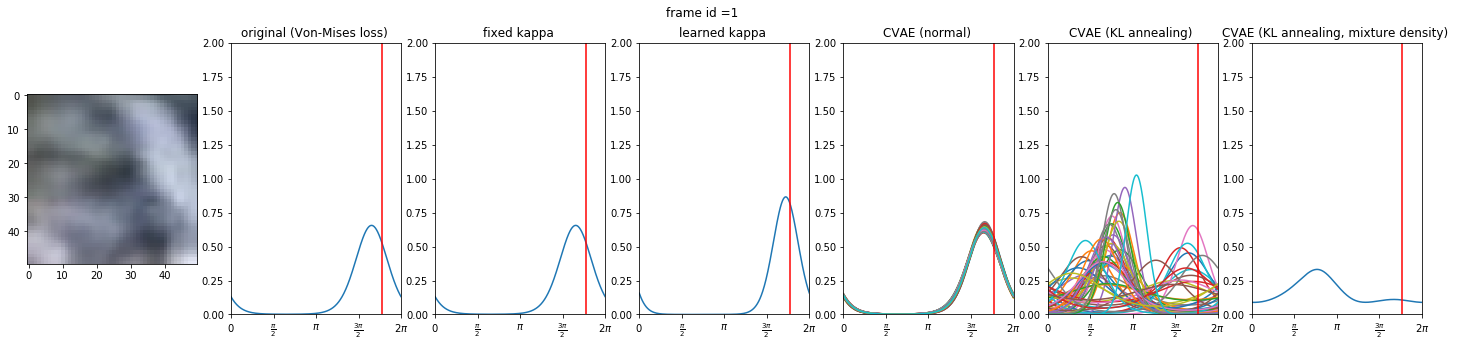

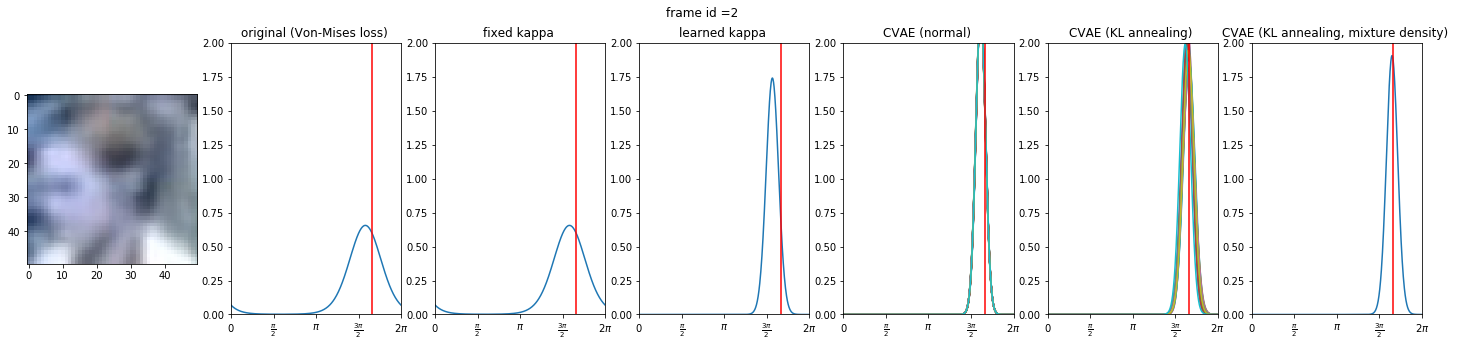

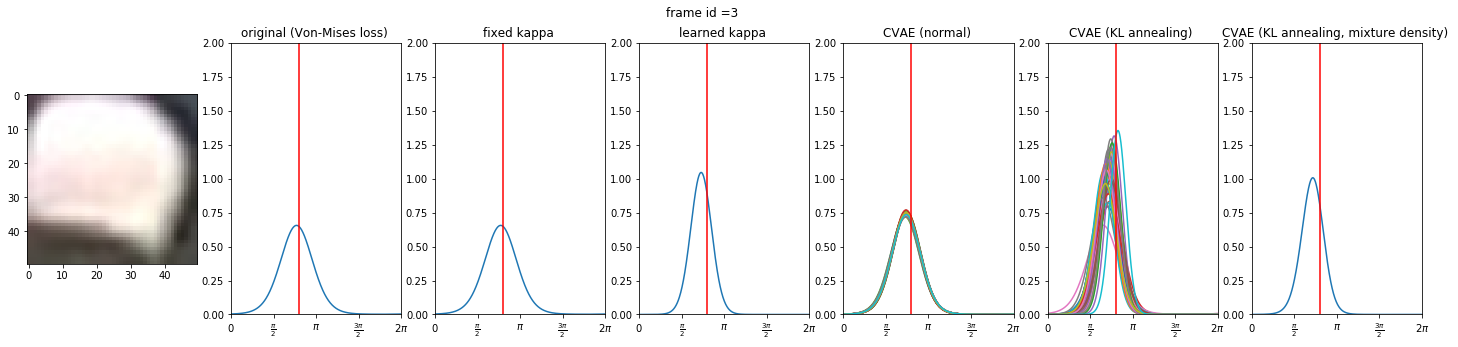

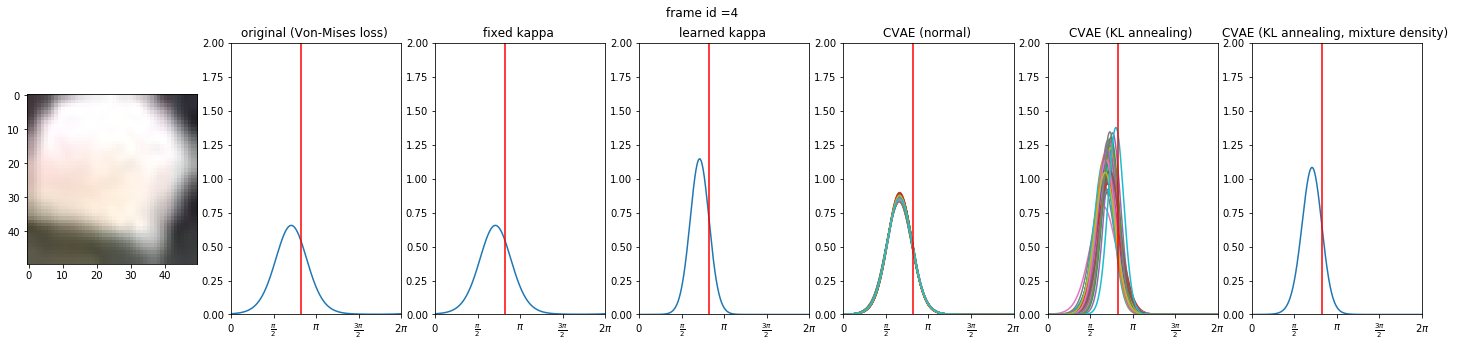

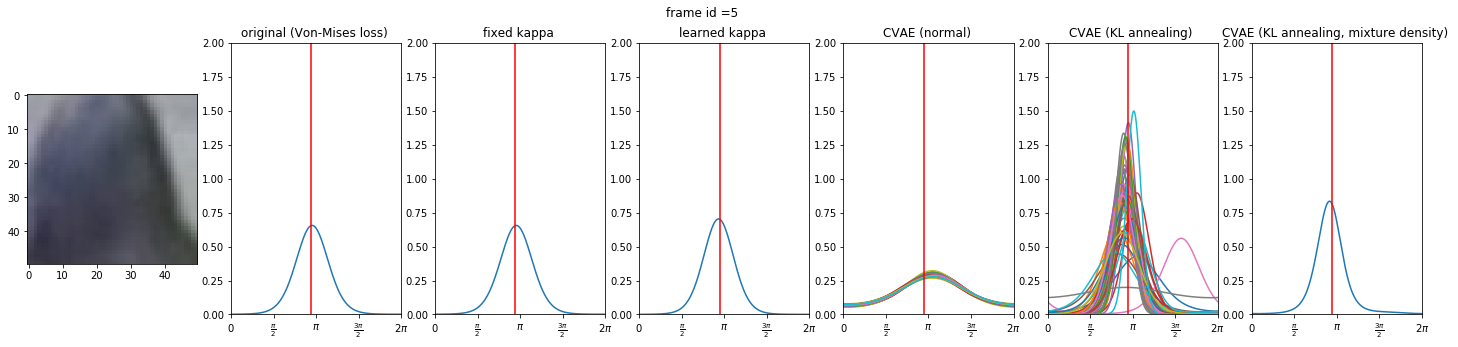

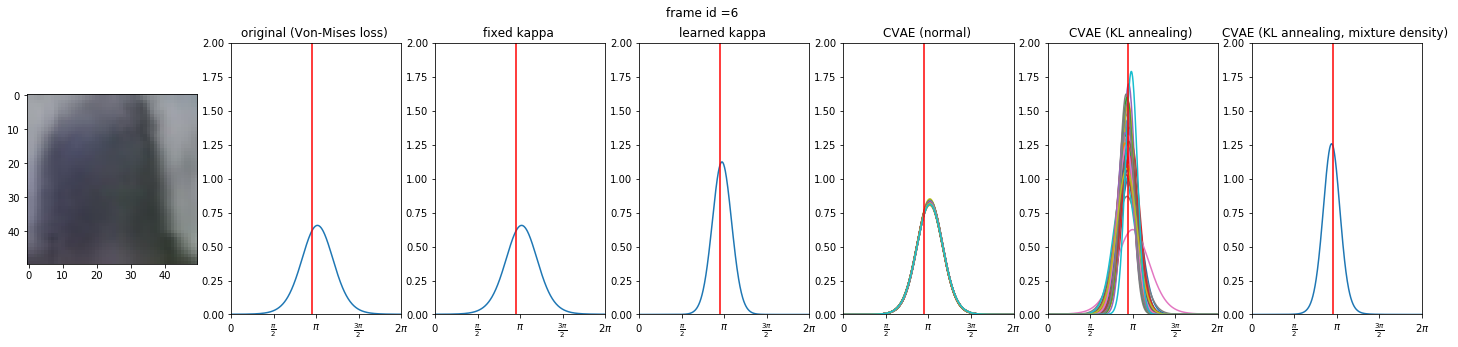

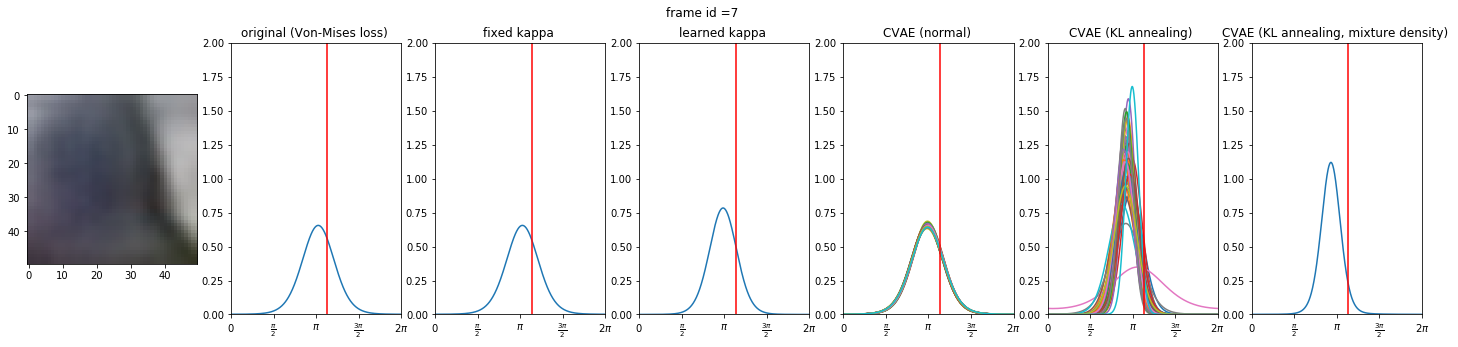

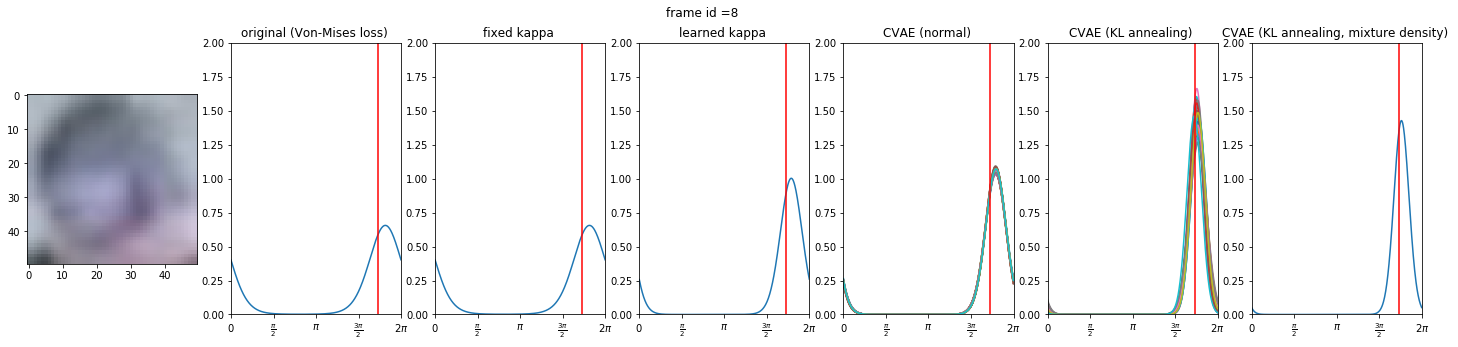

KeyboardInterrupt: 

In [33]:
import time 

for fid in range(0, 100):
    plot_vm_dists(fid)

In [ ]:
cvae_preds_full = cvae.full_model.predict([xte, yte_bit])

In [ ]:
mu_prior = cvae_preds_full[:, 0:cvae_best.n_u]
log_sigma_prior = cvae_preds_full[:, cvae_best.n_u:cvae_best.n_u*2]
mu_encoder = cvae_preds_full[:, cvae_best.n_u*2:cvae_best.n_u*3]
log_sigma_encoder = cvae_preds_full[:, cvae_best.n_u*3:cvae_best.n_u*4]
mu_pred = cvae_preds_full[:, cvae_best.n_u*4:cvae_best.n_u*4+2]
kappa_pred = cvae_preds_full[:, cvae_best.n_u*4+2:]

In [ ]:
np.exp(log_sigma_prior[2])

#### The problem is that encoder and prior generate exactly the same distributions for each input

$ p(u|x) = q(u|x,\phi) = p(u)$ 

In [ ]:
mu_prior[0:5]

In [ ]:
mu_encoder[0:5]

#### Generating predictions on random images

In [ ]:
black_img = np.zeros(xte[1].shape)
white_img = np.ones(xte[1].shape)
random_img1 = np.random.rand(xte[1].shape[0], xte[1].shape[1], xte[1].shape[2])
random_img2 = np.random.rand(xte[1].shape[0], xte[1].shape[1], xte[1].shape[2])
random_img3 = np.random.rand(xte[1].shape[0], xte[1].shape[1], xte[1].shape[2])

In [ ]:
cvae_best.full_model.predict

In [ ]:
cvae_best.decoder_model.predict(black_img.reshape([1,50,50,3]))

In [ ]:
def plot_cvae_preds(img, cvae_model, n_samples=10):
    x_vals = np.arange(0, 2*np.pi, 0.01)
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))
    axs[0].imshow(img)
    axs[1].set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
    axs[1].set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]) 
    axs[1].set_ylim([0, 2.0])
    for i in range(0, n_samples):
        preds = cvae_model.decoder_model.predict(img.reshape([1,50,50,3]))
        mu_preds = np.deg2rad(bit2deg(preds[:, 0:2]))
        kappa_preds = preds[:,2:]
        axs[1].plot(x_vals, np.squeeze(vm_pdf(x_vals, mu_preds[0], kappa_preds[0]))) 
    return

In [ ]:
for i in range(0,5):
    plot_cvae_preds(xte[i], cvaekl, 10)
plot_cvae_preds(black_img, cvaekl, 10)
plot_cvae_preds(white_img, cvaekl, 10)
plot_cvae_preds(random_img1, cvaekl, 10)
plot_cvae_preds(random_img2, cvaekl, 10)
plot_cvae_preds(random_img3, cvaekl, 10)

In [ ]:
loss = cvae_best.full_model.evaluate([xte, yte_bit],yte_bit, verbose=0)